In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

class DuelingDQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DuelingDQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)

        # Advantage stream
        self.advantage_fc = nn.Linear(64, output_size)

        # Value stream
        self.value_fc = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        advantage = self.advantage_fc(x)
        value = self.value_fc(x)

        # Combine value and advantage to get Q-values
        q_values = value + (advantage - advantage.mean())
        return q_values

# Define replay buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        samples = random.sample(self.buffer, batch_size)
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*samples)
        return np.array(state_batch), action_batch, reward_batch, np.array(next_state_batch), done_batch

    def __len__(self):
        return len(self.buffer)

# Define DQN agent
class DQNAgent:
    def __init__(self, state_size, action_size, capacity, batch_size, gamma, lr):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.action_size = action_size
        self.buffer = ReplayBuffer(capacity)
        self.batch_size = batch_size
        self.gamma = gamma
        self.q_network = DuelingDQN(state_size, action_size).to(self.device)
        self.target_network = DuelingDQN(state_size, action_size).to(self.device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

    def select_action(self, state, epsilon):
        if random.random() < epsilon:
            return random.randint(0, self.action_size - 1)
        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                q_values = self.q_network(state)
                return q_values.max(1)[1].item()

    def train(self):
        if len(self.buffer) < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.buffer.sample(self.batch_size)
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        # Compute Q targets
        with torch.no_grad():
            next_state_values = self.target_network(next_states).max(1)[0]
            q_targets = rewards + (1 - dones) * self.gamma * next_state_values

        # Compute Q values
        q_values = self.q_network(states)
        q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

        # Compute loss
        loss = nn.MSELoss()(q_values, q_targets)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

# Main training loop
def train_dueling_dqn(env, agent, num_episodes, max_steps, epsilon_start, epsilon_end, epsilon_decay):
    epsilon = epsilon_start
    rewards = []
    losses = []
    episode_states = []  # Collect states
    episode_actions = []  # Collect actions
    for episode in range(1, num_episodes + 1):
        state = env.reset()
        total_reward = 0
        episode_state = []  # Collect states for this episode
        episode_action = []  # Collect actions for this episode
        for step in range(max_steps):
            action = agent.select_action(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            agent.buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            agent.train()
            episode_state.append(state)  # Collect state
            episode_action.append(action)  # Collect action
            if done:
                break
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        rewards.append(total_reward)
        if episode % 10 == 0:
            agent.target_network.load_state_dict(agent.q_network.state_dict())
        losses.append(agent.train())
        episode_states.append(episode_state)
        episode_actions.append(episode_action)
        print(f"Episode {episode}/{num_episodes}, Total Reward: {total_reward}")

    # Plotting episode vs. reward
    plt.plot(range(1, num_episodes + 1), rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Episode vs. Total Reward')
    plt.show()

    # Plotting episode vs. loss
    plt.plot(range(1, num_episodes + 1), losses)
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.title('Episode vs. Loss')
    plt.show()

    return episode_states, episode_actions


/home/janmenjaya/.local/lib/python3.8/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/janmenjaya/.local/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/janmenjaya/.local/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/tmp/ipykernel_80508/205527935.py:77: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider conve

Episode 1/500, Total Reward: 24.0
Episode 2/500, Total Reward: 15.0
Episode 3/500, Total Reward: 11.0
Episode 4/500, Total Reward: 17.0
Episode 5/500, Total Reward: 11.0
Episode 6/500, Total Reward: 14.0
Episode 7/500, Total Reward: 36.0
Episode 8/500, Total Reward: 16.0
Episode 9/500, Total Reward: 24.0
Episode 10/500, Total Reward: 16.0
Episode 11/500, Total Reward: 21.0
Episode 12/500, Total Reward: 15.0
Episode 13/500, Total Reward: 25.0
Episode 14/500, Total Reward: 17.0
Episode 15/500, Total Reward: 11.0
Episode 16/500, Total Reward: 45.0
Episode 17/500, Total Reward: 12.0
Episode 18/500, Total Reward: 17.0
Episode 19/500, Total Reward: 13.0
Episode 20/500, Total Reward: 27.0
Episode 21/500, Total Reward: 61.0
Episode 22/500, Total Reward: 83.0
Episode 23/500, Total Reward: 9.0
Episode 24/500, Total Reward: 50.0
Episode 25/500, Total Reward: 12.0
Episode 26/500, Total Reward: 35.0
Episode 27/500, Total Reward: 31.0
Episode 28/500, Total Reward: 52.0
Episode 29/500, Total Reward: 

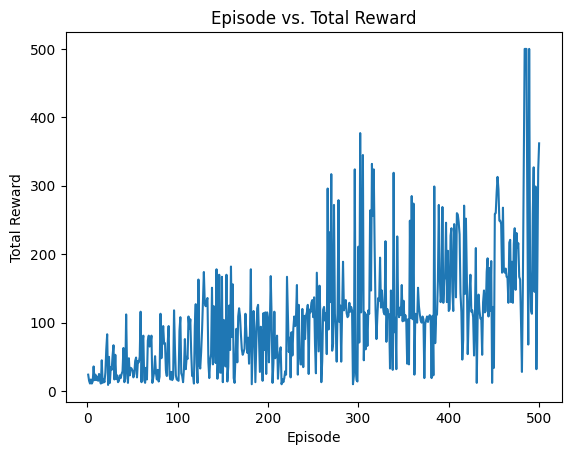

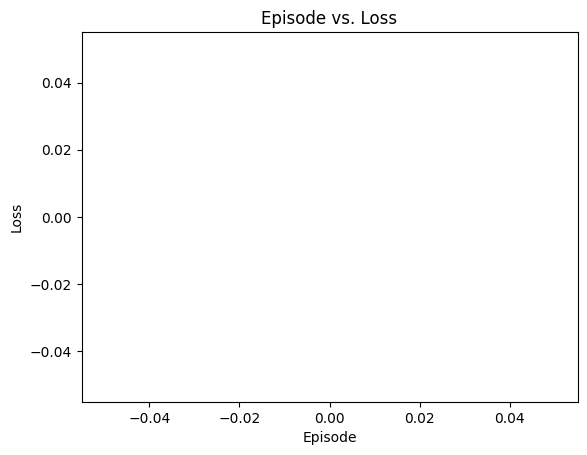

/home/janmenjaya/.local/lib/python3.8/site-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/home/janmenjaya/.local/lib/python3.8/site-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/home/janmenjaya/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:2832: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lazr')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/home/janmenjaya/.local/lib/python3.8/site-packages/pkg_

In [2]:
import matplotlib.animation as animation

if __name__ == "__main__":
    import gym
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    capacity = 10000
    batch_size = 64
    gamma = 0.99
    lr = 1e-3
    epsilon_start = 1.0
    epsilon_end = 0.01
    epsilon_decay = 0.995

    agent = DQNAgent(state_size, action_size, capacity, batch_size, gamma, lr)
    num_episodes = 500
    max_steps = 1000
    episode_states, episode_actions = train_dueling_dqn(env, agent, num_episodes, max_steps, epsilon_start, epsilon_end, epsilon_decay)

    # Function to animate frames
    def animate_frames(frames):
        fig = plt.figure()
        plt.axis('off')
        ims = [[plt.imshow(frame, animated=True)] for frame in frames]
        ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True)
        ani.save('simulation.gif', writer='pillow', fps=30)

    # Simulate agent's behavior and capture frames
    frames = []
    for episode_state, episode_action in zip(episode_states, episode_actions):
        state = env.reset()
        for action in episode_action:
            frame = env.render(mode='rgb_array')
            frames.append(frame)
            next_state, _, done, _ = env.step(action)
            state = next_state
            if done:
                break

    # Call function to animate frames and save as GIF
    animate_frames(frames)

    env.close()